#  DC Total Bike Share (Month Aggregated)

**Code used to aggregate by month/day**

In [674]:
# #Group dates
# bike_df.Date = pd.to_datetime(bike_df.Date)
# bike_df['Month'] = bike_df.Date.dt.month
# bike_df['Day'] = bike_df.Date.dt.day

# bike_df = bike_df.dropna(how = 'any')

# bike_df.drop(bike_df[['Date', 'DAILYSnowDepth','DAILYSnowDepth']], axis = 1, inplace = True)

# #Create stats dict for column stats
# f = {'Customer_sum': 'sum', 'Subscriber_sum': 'sum', 'Total_Count sum': 'sum', 'Season': 'mean', 'Holiday': 'mean', 'Duration_mean': 'mean', 'DAILYAverageDryBulbTemp': 'mean', 'DAILYDeptFromNormalAverageTemp': 'mean', 'DAILYAverageRelativeHumidity': 'mean', 'DAILYCoolingDegreeDays': 'mean', 'DAILYSunrise': 'mean', 'DAILYSunset': 'mean', 'DAILYAverageStationPressure': 'mean', 'DAILYAverageWindSpeed': 'mean', 'DAILYSustainedWindSpeed': 'mean', 'DAILYSustainedWindDirection': 'mean'}

# #Aggregate data by day
# bike_df = bike_df.groupby(['Month', 'Day']).agg(f) #Groupby day and apply
# bike_df.to_csv('DC_aggregated.csv')

**Import pacakges**

In [675]:
import warnings
warnings.filterwarnings('ignore')

In [676]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smgraph
import scipy.stats as stats

from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import ExtraTreesRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, f1_score, metrics
from math import sqrt

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [677]:
#Import data files
bike_df = pd.read_csv('DC_aggregated.csv')
model_df = bike_df.copy()

In [678]:
model_df.head()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,DAILYSunset,DAILYAverageDryBulbTemp,DAILYSustainedWindDirection,DAILYAverageRelativeHumidity,DAILYAverageStationPressure,DAILYDeptFromNormalAverageTemp,DAILYSunrise,Duration_mean,DAILYAverageWindSpeed,DAILYCoolingDegreeDays,DAILYSustainedWindSpeed,Season_Name
0,1,1,229,1691,1920,1,1,1658.0,39.333333,233.333333,53.666667,30.140000,2.933333,727.0,13.700154,7.066667,0.0,16.0,Winter
1,1,2,429,3466,3895,1,0,1659.0,41.000000,300.000000,54.000000,30.115000,4.700000,727.0,11.552192,4.550000,0.0,13.5,Winter
2,1,3,176,1920,2096,1,0,1700.0,40.500000,200.000000,69.500000,30.095000,4.300000,727.0,11.751971,5.600000,0.0,18.5,Winter
3,1,4,105,4336,4441,1,0,1700.0,36.666667,263.333333,57.666667,30.076667,0.566667,727.0,14.673400,12.033333,0.0,24.0,Winter
4,1,5,96,5313,5409,1,0,1701.0,32.500000,155.000000,37.500000,30.340000,-3.500000,727.0,9.947841,12.250000,0.0,28.0,Winter


In [679]:
#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Outlier adjust
# model_df = model_df[model_df['Total_Count sum'] > 5000]
#Chose to keep these points in the model as the are all from the winter season (below)

In [680]:
model_df[model_df['Total_Count sum'] < 5000]

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,DAILYSunset,DAILYAverageDryBulbTemp,DAILYSustainedWindDirection,...,DAILYDeptFromNormalAverageTemp,DAILYSunrise,Duration_mean,DAILYAverageWindSpeed,DAILYCoolingDegreeDays,DAILYSustainedWindSpeed,Fall,Spring,Summer,Winter
0,1,1,229,1691,1920,1,1,1658.000000,39.333333,233.333333,...,2.933333,727.000000,13.700154,7.066667,0.000000,16.000000,0.0,0.0,0.0,1.0
1,1,2,429,3466,3895,1,0,1659.000000,41.000000,300.000000,...,4.700000,727.000000,11.552192,4.550000,0.000000,13.500000,0.0,0.0,0.0,1.0
2,1,3,176,1920,2096,1,0,1700.000000,40.500000,200.000000,...,4.300000,727.000000,11.751971,5.600000,0.000000,18.500000,0.0,0.0,0.0,1.0
3,1,4,105,4336,4441,1,0,1700.000000,36.666667,263.333333,...,0.566667,727.000000,14.673400,12.033333,0.000000,24.000000,0.0,0.0,0.0,1.0
7,1,8,97,3943,4040,1,0,1704.000000,30.500000,125.000000,...,-5.400000,727.000000,10.313021,7.950000,0.000000,16.500000,0.0,0.0,0.0,1.0
8,1,9,103,3348,3451,1,0,1705.000000,38.333333,103.333333,...,2.533333,727.000000,10.954655,7.100000,0.000000,17.000000,0.0,0.0,0.0,1.0
9,1,10,88,2320,2408,1,0,1706.000000,36.000000,196.666667,...,0.200000,726.000000,10.607632,9.333333,0.000000,19.666667,0.0,0.0,0.0,1.0
10,1,11,141,3659,3800,1,0,1707.000000,38.000000,253.333333,...,2.200000,726.000000,10.830762,6.900000,0.000000,18.666667,0.0,0.0,0.0,1.0
11,1,12,197,4106,4303,1,0,1708.000000,40.666667,323.333333,...,4.966667,726.000000,11.871557,8.966667,0.000000,21.666667,0.0,0.0,0.0,1.0
16,1,17,310,3725,4035,1,0,1714.000000,36.333333,246.666667,...,0.633333,724.000000,11.616401,7.233333,0.000000,16.000000,0.0,0.0,0.0,1.0


# Variable Creation

In [681]:
#Create dependent variable
y = model_df['Total_Count sum']

#Create independent variables
X = model_df.ix[:,'Holiday': 'Winter']

# Data Set Decriptive Stats

In [682]:
model_df.describe()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,DAILYSunset,DAILYAverageDryBulbTemp,DAILYSustainedWindDirection,...,DAILYDeptFromNormalAverageTemp,DAILYSunrise,Duration_mean,DAILYAverageWindSpeed,DAILYCoolingDegreeDays,DAILYSustainedWindSpeed,Fall,Spring,Summer,Winter
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,...,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,6.539548,15.330508,7689.115819,17890.985876,25580.101695,2.511299,0.042373,1803.289783,59.734228,214.781073,...,1.439878,583.179143,15.391224,8.272905,4.950565,18.954802,0.251412,0.254237,0.251412,0.242938
std,3.444397,8.565748,7775.905529,10647.660496,17499.199475,1.114487,0.201724,99.204148,16.379841,71.348700,...,4.635517,96.491973,3.710030,2.109266,6.378695,3.948450,0.434439,0.436048,0.434439,0.429465
min,1.000000,1.000000,4.000000,219.000000,242.000000,1.000000,0.000000,1646.000000,25.000000,10.000000,...,-13.300000,442.000000,9.037804,3.200000,0.000000,10.333333,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,635.250000,8638.750000,9415.000000,2.000000,0.000000,1718.750000,46.000000,173.333333,...,-0.991667,509.500000,12.022725,6.900000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,15.000000,4689.500000,17574.000000,23747.500000,3.000000,0.000000,1816.916666,60.333333,215.833333,...,1.516667,577.625000,15.045446,8.000000,0.666667,18.333333,0.000000,0.000000,0.000000,0.000000
75%,9.750000,23.000000,13586.750000,27758.500000,43157.750000,3.750000,0.000000,1909.187500,76.500000,266.666667,...,4.112500,654.750000,18.400064,9.525000,11.500000,21.333333,0.750000,1.000000,0.750000,0.000000
max,12.000000,30.000000,41421.000000,37494.000000,60785.000000,4.000000,1.000000,1937.000000,84.000000,360.000000,...,18.333333,727.000000,30.281049,17.100000,19.000000,33.000000,1.000000,1.000000,1.000000,1.000000


# Dependent Variable Distributions

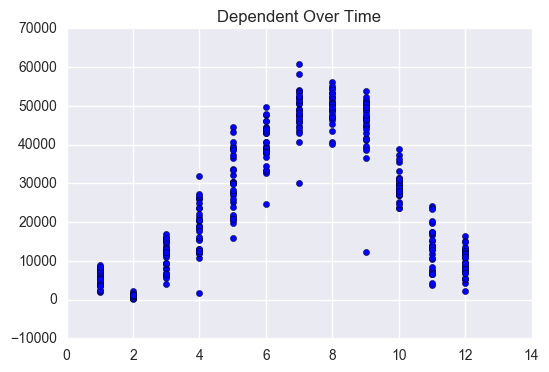

In [683]:
#Count over time
plt.scatter(model_df.Month, model_df['Total_Count sum'])
plt.title('Dependent Over Time')

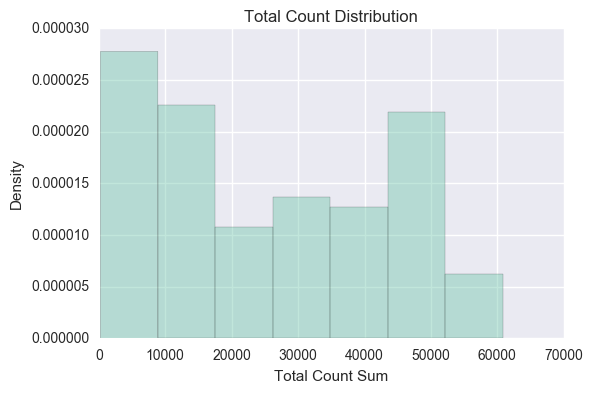

In [684]:
#Dependent distributions
ax = sns.distplot(model_df['Total_Count sum'], kde = False, rug = False, norm_hist = True)
plt.title('Total Count Distribution')
plt.xlabel('Total Count Sum')
ax.set_ylabel('Density')
plt.show()

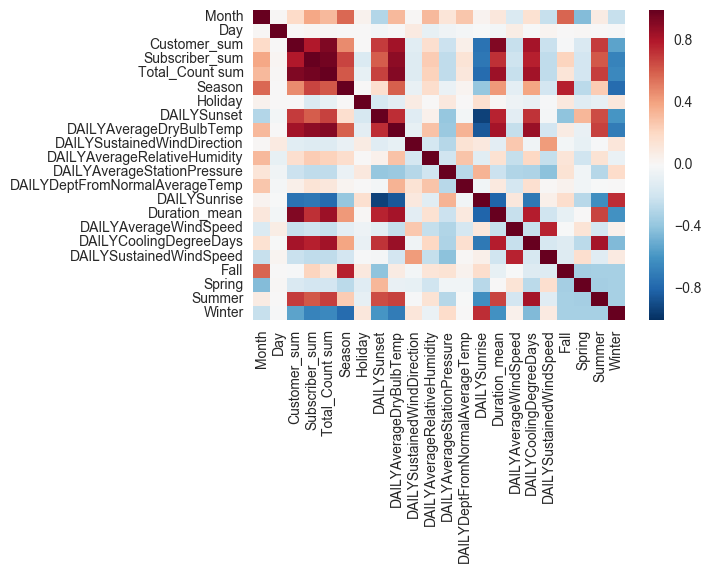

In [685]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [686]:
#Correlation Values List
corr = pd.DataFrame(model_df.corr())
corr.dropna(how='any')

#Dropped (Based on correlation and heatmap > .90): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,DAILYSunset,DAILYAverageDryBulbTemp,DAILYSustainedWindDirection,...,DAILYDeptFromNormalAverageTemp,DAILYSunrise,Duration_mean,DAILYAverageWindSpeed,DAILYCoolingDegreeDays,DAILYSustainedWindSpeed,Fall,Spring,Summer,Winter
Month,1.000000,0.008053,0.190812,0.390267,0.322253,0.572915,0.040391,-0.293529,0.320513,0.012240,...,0.274100,0.033283,0.111175,-0.144633,0.150302,-0.232746,0.581157,-0.431099,0.079475,-0.230576
Day,0.008053,1.000000,0.001784,0.016541,0.010857,0.005394,0.000069,-0.023702,0.002203,0.087822,...,-0.019938,-0.003640,-0.028287,0.077427,-0.004561,0.024321,0.000445,0.011570,0.000445,-0.012647
Customer_sum,0.190812,0.001784,1.000000,0.799470,0.930808,0.470203,0.001406,0.700408,0.838952,-0.116485,...,0.062319,-0.739762,0.924200,-0.233239,0.829442,-0.225433,-0.011196,-0.153012,0.696700,-0.538087
Subscriber_sum,0.390267,0.016541,0.799470,1.000000,0.963716,0.671892,-0.141950,0.606547,0.897356,-0.126705,...,0.138084,-0.719392,0.729754,-0.207177,0.780226,-0.254077,0.222043,-0.187204,0.622703,-0.664456
Total_Count sum,0.322253,0.010857,0.930808,0.963716,1.000000,0.617762,-0.085747,0.680295,0.918806,-0.128857,...,0.111711,-0.766444,0.854705,-0.229702,0.843309,-0.254770,0.130130,-0.181899,0.688477,-0.643402
Season,0.572915,0.005394,0.470203,0.671892,0.617762,1.000000,0.004165,0.166746,0.598074,-0.072274,...,0.028842,-0.390468,0.432993,-0.097386,0.395116,-0.183355,0.775209,-0.268246,0.254480,-0.769257
Holiday,0.040391,0.000069,0.001406,-0.141950,-0.085747,0.004165,1.000000,-0.166193,-0.106395,0.079213,...,0.001571,0.156281,0.012292,-0.049226,-0.077074,-0.014483,0.104372,-0.122819,-0.089579,0.109737
DAILYSunset,-0.293529,-0.023702,0.700408,0.606547,0.680295,0.166746,-0.166193,1.000000,0.738468,-0.124238,...,-0.025886,-0.935568,0.767419,-0.102074,0.719380,-0.023317,-0.405510,0.334474,0.654289,-0.591262
DAILYAverageDryBulbTemp,0.320513,0.002203,0.838952,0.897356,0.918806,0.598074,-0.106395,0.738468,1.000000,-0.078154,...,0.348882,-0.844660,0.834706,-0.236236,0.860533,-0.183120,0.080012,-0.077903,0.686211,-0.696001
DAILYSustainedWindDirection,0.012240,0.087822,-0.116485,-0.126705,-0.128857,-0.072274,0.079213,-0.124238,-0.078154,1.000000,...,0.142416,0.106164,-0.108533,0.270908,-0.046458,0.426135,-0.023581,-0.084405,-0.014975,0.124700


# Categorical Boxplots

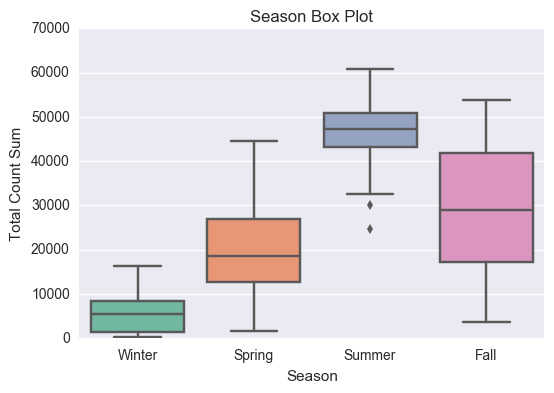

In [687]:
#Season df for labels
seasons_df = model_df[['Total_Count sum', 'Season']]

#Seasons Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
plt.title('Season Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Season')
plt.show()

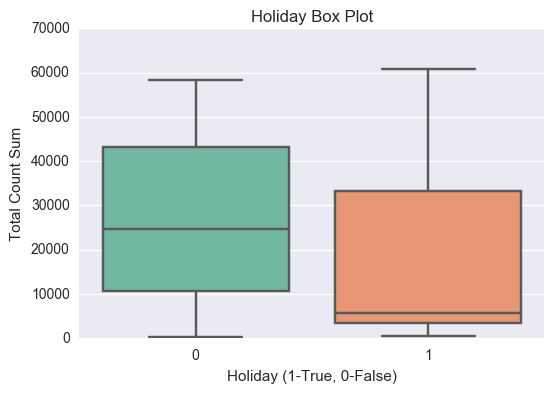

In [688]:
#Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
plt.title('Holiday Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

# Feature Importance

[0.0016623264380798697, 0.027013589760414757, 0.56302716567695887, 0.0065640603806072203, 0.0041915617508404557, 0.0069552662550715783, 0.0063738920646431805, 0.092310448545189661, 0.093863274727897419, 0.0040191939893633091, 0.10128596508898002, 0.0061512370042818929, 0.0087078725527209074, 0.04308047747929724, 0.00066941634788181118, 0.03412425193777182]


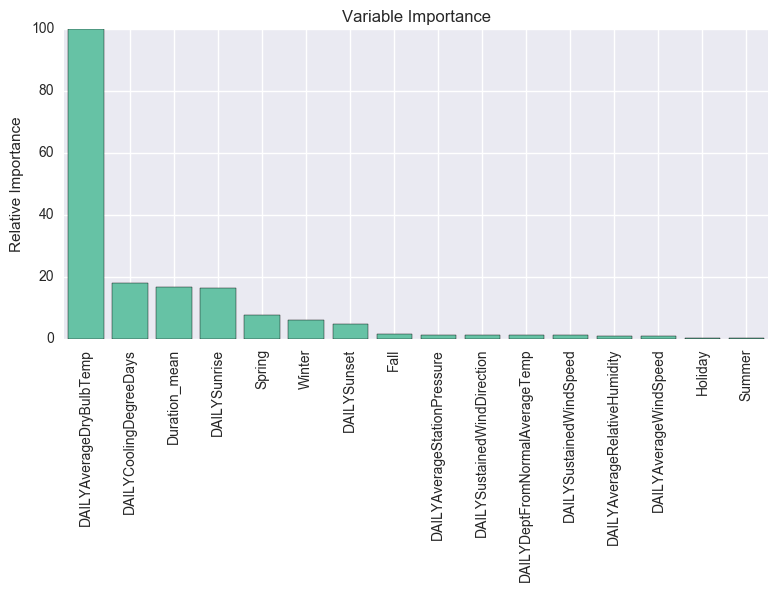

In [689]:
# fit an Extra Trees model to the data (fits n randomized decision trees on subsets of the data)
#uses averaging
model = ExtraTreesRegressor()
model.fit(X, y)

# Plot feature importance
feature_importance = model.feature_importances_
# normalize importances relative to max importance
print(list(feature_importance))
feature_importance = 100.0 * (feature_importance / feature_importance.max()) #Normalize
sorted_idx = np.argsort(feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 2)
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, X.columns[sorted_idx], rotation='vertical')
plt.ylabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [690]:
#Final model variables to drop (In order of highest p-value > .05)
X.drop(['DAILYSustainedWindDirection', 'DAILYAverageStationPressure', 'DAILYAverageWindSpeed', 'DAILYSustainedWindSpeed', 'DAILYAverageRelativeHumidity', 'DAILYSustainedWindDirection', 'DAILYAverageStationPressure', 'DAILYDeptFromNormalAverageTemp', 'DAILYSunset', 'DAILYSunrise'], axis = 1, inplace = True)

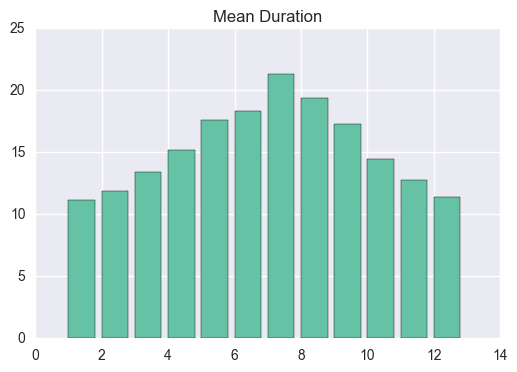

In [691]:
#Average Duration
duration = (model_df.groupby(model_df.Month, as_index = False).mean().groupby(model_df.Duration_mean).mean())
plt.bar(duration.Month, duration.Duration_mean)
plt.title('Mean Duration')

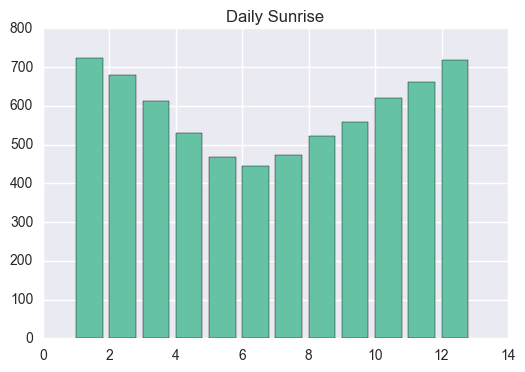

In [692]:
#Average Daily Sunrise
sunrise = (model_df.groupby(model_df.Month, as_index = False).mean().groupby(model_df.DAILYSunrise).mean())
plot = plt.bar(duration.Month, duration.DAILYSunrise)
plt.title('Daily Sunrise')

In [693]:
# #Final model variables to drop (In order of highest p-value > .05)
# X.drop(['DAILYSustainedWindDirection', 'DAILYAverageStationPressure', 'DAILYAverageWindSpeed', 'DAILYSustainedWindSpeed', 'DAILYAverageRelativeHumidity', 'DAILYSustainedWindDirection', 'DAILYAverageStationPressure', 'DAILYDeptFromNormalAverageTemp', 'DAILYSunset'], axis = 1, inplace = True)
# #  'Winter','Spring', 'Summer', 'Fall', 'Holiday'

# Training and Test Sets

In [694]:
#Training/Test set from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283, 8)
(283,)
(71, 8)
(71,)


# Linear Regression Model

In [695]:
#Linear Regression Model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Total_Count sum   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     351.4
Date:                Sun, 04 Jun 2017   Prob (F-statistic):          3.53e-133
Time:                        17:30:20   Log-Likelihood:                -2839.8
No. Observations:                 283   AIC:                             5696.
Df Residuals:                     275   BIC:                             5725.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Holiday                 -4173.4558   1777.698     -2.348      0.020     -7673.082  -673.830
DAILYAverageDryBulbTemp   478.4057     61.141      7.825      0.000       358.042   598.769
Duration_mean            1501.4539    189.000      7.944      0.000      1129.384  1873.524
DAILYCoolingDegreeDays    471.2785    149.927      3.143      0.002       176.127   766.430
Fall                    -2.407e+04   3680.996     -6.540      0.000     -3.13e+04 -1.68e+04
Spring                  -3.191e+04   3741.450     -8.527      0.000     -3.93e+04 -2.45e+04
Summer                  -2.703e+04   3912.532     -6.909      0.000     -3.47e+04 -1.93e+04
Winter                  -3.006e+04   2781.614    -10.805      0.000     -3.55e+04 -2.46e+04
==============================================================================
Omnibus:                        7.650   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.772
Skew:                          -0.327   Prob(JB):                       0.0205
Kurtosis:                       3.481   Cond. No.                     1.33e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [696]:
#Calculate residuals
train_preds = results.fittedvalues
res = y_train - predicted

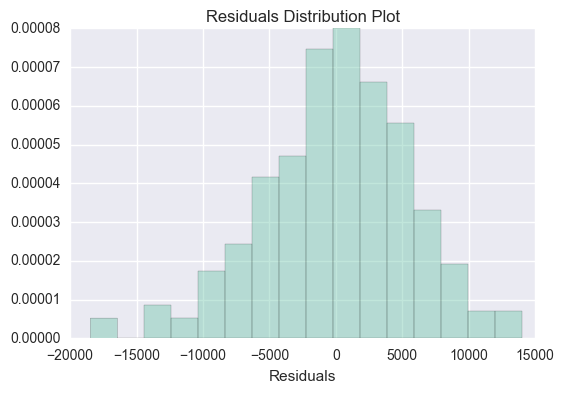

In [697]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.title('Residuals Distribution Plot')
plt.xlabel('Residuals')
plt.show()

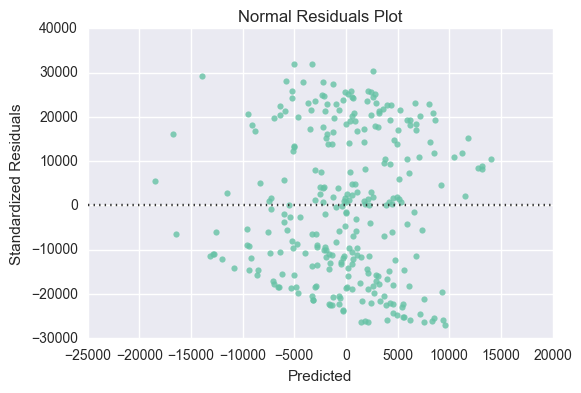

In [698]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.title('Normal Residuals Plot')
plt.show()

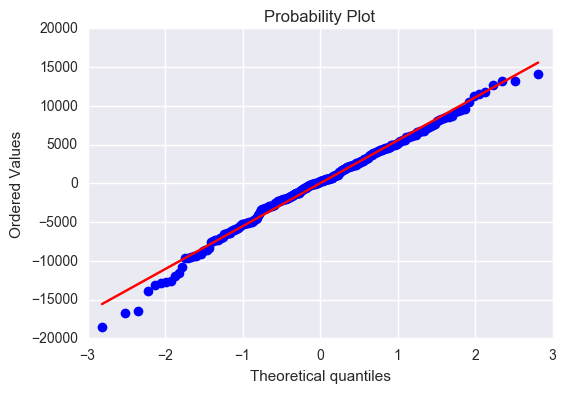

In [699]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Predictions

Training Set Root Mean Square Error: 5518.530122376898
Test Set Root Mean Square Error: 6031.025146283892


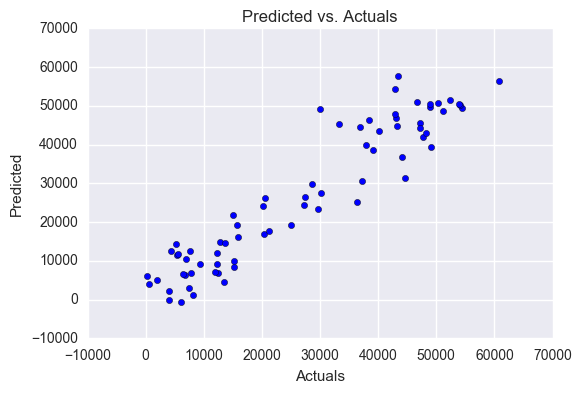

In [700]:
#Prediction on test set, plot predicted vs. actuals
test_preds = results.predict(X_test.astype(float))
plt.scatter(y_test, test_preds)
plt.title('Predicted vs. Actuals')
plt.xlabel('Actuals')
plt.ylabel('Predicted')
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds)) #RMSE
print('Training Set Root Mean Square Error: ' + str(train_rmse))
print('Test Set Root Mean Square Error: ' + str(test_rmse))